#### GPU / CPU Device

In [1]:
import torch


device = torch.device('cpu')

if torch.cuda.is_available():

    device = torch.device('cuda')

#### Data Preprocessing

In [2]:
import torchvision


class SquashTransform:

    def __call__(self, inputs):
        return 2 * inputs - 1


data_train = torchvision.datasets.ImageFolder(
    'C:/Users/avdra/OneDrive/Desktop/GAN-Enabled_Disease_Detection/COVID/downscaled_scans_train_pennapps',
    transform=torchvision.transforms.Compose([
#         torchvision.transforms.Resize((64, 64)),
        torchvision.transforms.ToTensor(),
        SquashTransform()
    ])
)


In [3]:
from math import ceil

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, 
    drop_last=True
)

num_steps =  ceil(len(data_train) / BATCH_SIZE)

num_steps

89

#### Global Dimensions

In [4]:
# Number of channels in the training images.
# For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Size of labels dimension
nl = 2

#### Generator Design

Reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [5]:
class Generator(torch.nn.Module):

    def __init__(self):

        super(Generator, self).__init__()

        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(
                in_channels=nz + nl,
                out_channels=ngf * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 8
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 8,
                out_channels=ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 4
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 4,
                out_channels=ngf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 2
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 2,
                out_channels=ngf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf) x 32 x 32
            torch.nn.ConvTranspose2d(
                in_channels=ngf,
                out_channels=nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, inputs, condition):
        # Concatenate Noise and Condition
        cat_inputs = torch.cat(
            (inputs, condition),
            dim=1
        )
        
        # Reshape the latent vector into a feature map.
        cat_inputs = cat_inputs.unsqueeze(2).unsqueeze(3)

        return self.main(cat_inputs)

#### Discriminator Design

In [6]:
class Discriminator(torch.nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(
                in_channels=nc,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 2
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 4
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 8
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
        )
        
        # Categorical Classifier
        self.clf = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=ndf * 8 * 4 * 4,
                out_features=nl,
                bias=True
            ),
            torch.nn.Softmax(dim=1)
        )
        
        # Real / Fake Classifier
        self.police = torch.nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(
                in_channels=ndf * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        
        features = self.main(input)
        valid = self.police(features).view(-1, 1)
        clf = self.clf(features.view(features.shape[0], -1))
        return valid, clf

#### Weight Initialization

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
netD = Discriminator().to(device)
netG = Generator().to(device)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(102, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#### Optimizer

In [8]:
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(
    netD.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999)
)

optimizerG = torch.optim.Adam(
    netG.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999)
)

In [9]:
num_examples = 10

fixed_noise = torch.randn(
    num_examples, nz
).to(device)

fixed_noise_train = torch.randn(
    1, nz
).to(device)


real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

c1 = torch.nn.BCELoss()
# c2 = torch.nn.CrossEntropyLoss()

#### Categorical Cross-Entropy

In [10]:
def c2(input, target):

    _, labels = target.max(dim=1)

    return torch.nn.CrossEntropyLoss()(input, labels)

#### One Hot Encoding

In [11]:
def encodeOneHot(labels):
    ret = torch.FloatTensor(labels.shape[0], nl)
    ret.zero_()
    ret.scatter_(dim=1, index=labels.view(-1, 1), value=1)
    return ret



fixed_conditions = encodeOneHot(
    torch.randint(
        0,
        nl,
        (num_examples, 1)
    )
).to(device)

fixed_conditions_train_neg = torch.Tensor([[1 , 0]]).to(device)
fixed_conditions_train_pos = torch.Tensor([[0 , 1]]).to(device)



#### Train Discriminator

In [12]:
def trainD(images, labels):

    real_images = images.to(device)
    real_conditions = encodeOneHot(labels).to(device)

    fake_conditions = encodeOneHot(
        torch.randint(
            0,
            nl,
            (BATCH_SIZE, 1)
        )
    ).to(device)

    fake_images = netG(
        torch.randn(
            BATCH_SIZE, nz
        ).to(device),
        fake_conditions  
    )

    optimizerD.zero_grad()

    real_valid, real_clf = netD(real_images)
    fake_valid, fake_clf = netD(fake_images)

    l_s = c1(
        real_valid, real_labels
    ) + c1(
        fake_valid, fake_labels
    )

    l_c = c2(
        real_clf, real_conditions
    ) + c2(
        fake_clf, fake_conditions
    )

    d_loss = l_s + l_c

    d_loss.backward()

    optimizerD.step()

    return d_loss


#### Train Generator

In [13]:
def trainG(labels):
        
    conditions = encodeOneHot(labels).to(device)

    z = torch.randn(
        BATCH_SIZE, nz
    ).to(device)

    netG.zero_grad()

    valid_outputs, clf_outputs = netD(
        netG(
            z,
            conditions
        )
    )

    ls = c1(valid_outputs, real_labels)
    lc = c2(clf_outputs, conditions)

    loss = lc + ls

    loss.backward()

    optimizerG.step()

    return loss

#### Restore Checkpoint

In [14]:
'''
import os


if os.path.exists('./Para-GAN_gen.pytorch'):

    netG.load_state_dict(torch.load('./Para-GAN_gen.pytorch'))

if os.path.exists('./Para-GAN_disc.pytorch'):

    netD.load_state_dict(torch.load('./Para-GAN_disc.pytorch'))

if os.path.exists('./Para-GAN_optGen.pytorch'):

    optimizerG.load_state_dict(torch.load('./Para-GAN_optGen.pytorch'))

if os.path.exists('./Para-GAN_optDisc.pytorch'):

    optimizerD.load_state_dict(torch.load('./Para-GAN_optDisc.pytorch'))


'''

"\nimport os\n\n\nif os.path.exists('./Para-GAN_gen.pytorch'):\n\n    netG.load_state_dict(torch.load('./Para-GAN_gen.pytorch'))\n\nif os.path.exists('./Para-GAN_disc.pytorch'):\n\n    netD.load_state_dict(torch.load('./Para-GAN_disc.pytorch'))\n\nif os.path.exists('./Para-GAN_optGen.pytorch'):\n\n    optimizerG.load_state_dict(torch.load('./Para-GAN_optGen.pytorch'))\n\nif os.path.exists('./Para-GAN_optDisc.pytorch'):\n\n    optimizerD.load_state_dict(torch.load('./Para-GAN_optDisc.pytorch'))\n\n\n"

#### Train Network

E:1, G Loss:0.10060926526784897, D Loss:2.0629849433898926


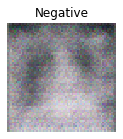

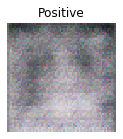

E:2, G Loss:0.051000650972127914, D Loss:2.2656755447387695


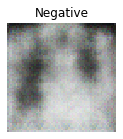

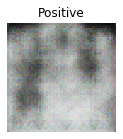

E:3, G Loss:0.021760335192084312, D Loss:1.8511680364608765


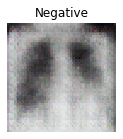

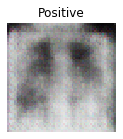

E:4, G Loss:0.05372843146324158, D Loss:1.6724743843078613


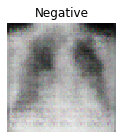

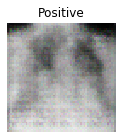

E:5, G Loss:0.07611600309610367, D Loss:1.5968228578567505


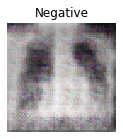

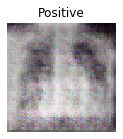

E:6, G Loss:0.0328359380364418, D Loss:1.7545251846313477


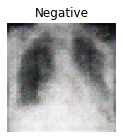

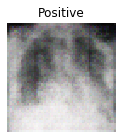

E:7, G Loss:0.04115452989935875, D Loss:1.7374904155731201


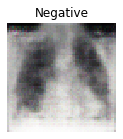

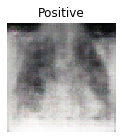

E:8, G Loss:0.0548037588596344, D Loss:1.6082195043563843


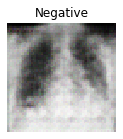

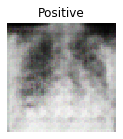

E:9, G Loss:0.04397115856409073, D Loss:1.6275665760040283


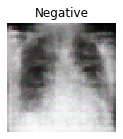

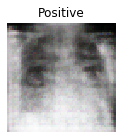

E:10, G Loss:0.037377920001745224, D Loss:1.642561674118042


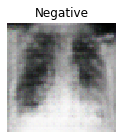

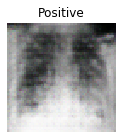

E:11, G Loss:0.05331205204129219, D Loss:1.5368117094039917


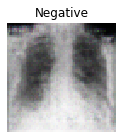

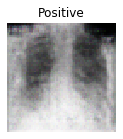

E:12, G Loss:0.061807263642549515, D Loss:1.5423482656478882


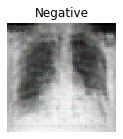

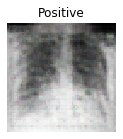

E:13, G Loss:0.03535573557019234, D Loss:1.6059691905975342


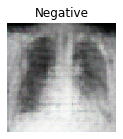

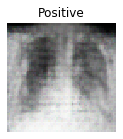

E:14, G Loss:0.06699478626251221, D Loss:1.4986977577209473


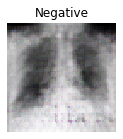

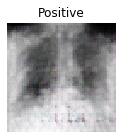

E:15, G Loss:0.026721181347966194, D Loss:1.5221283435821533


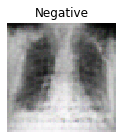

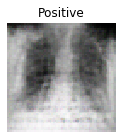

E:16, G Loss:0.04737059399485588, D Loss:1.4768565893173218


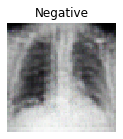

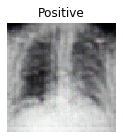

E:17, G Loss:0.03361039608716965, D Loss:1.4332295656204224


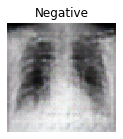

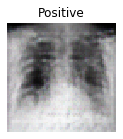

E:18, G Loss:0.07823212444782257, D Loss:1.5130510330200195


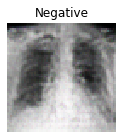

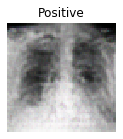

E:19, G Loss:0.06248064711689949, D Loss:1.4042236804962158


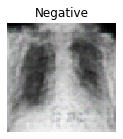

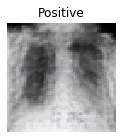

E:20, G Loss:0.020203053951263428, D Loss:1.4797402620315552


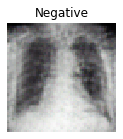

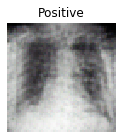

E:21, G Loss:0.049615636467933655, D Loss:1.355408787727356


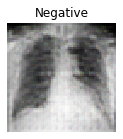

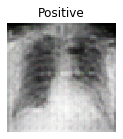

E:22, G Loss:0.0297431368380785, D Loss:1.4634649753570557


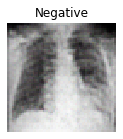

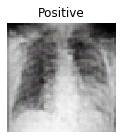

E:23, G Loss:0.044196717441082, D Loss:1.4051387310028076


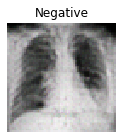

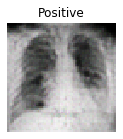

E:24, G Loss:0.03207753598690033, D Loss:1.4103081226348877


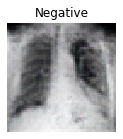

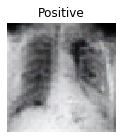

E:25, G Loss:0.06992491334676743, D Loss:1.3467155694961548


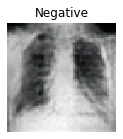

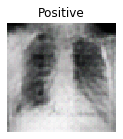

E:26, G Loss:0.045636069029569626, D Loss:1.397135615348816


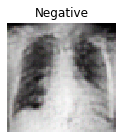

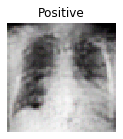

E:27, G Loss:0.08333583176136017, D Loss:1.4448105096817017


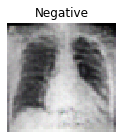

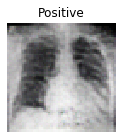

E:28, G Loss:0.05597102269530296, D Loss:1.339445948600769


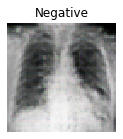

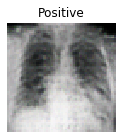

E:29, G Loss:0.04398467391729355, D Loss:1.361711025238037


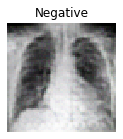

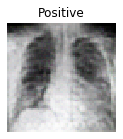

E:30, G Loss:0.03749702870845795, D Loss:1.3844984769821167


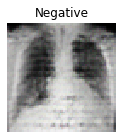

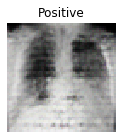

E:31, G Loss:0.06677525490522385, D Loss:1.3681257963180542


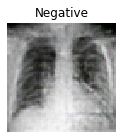

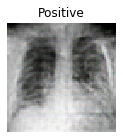

E:32, G Loss:0.03462333232164383, D Loss:1.3790533542633057


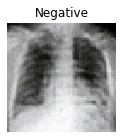

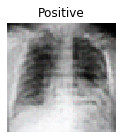

E:33, G Loss:0.06158103421330452, D Loss:1.3143025636672974


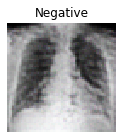

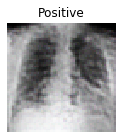

E:34, G Loss:0.05644720792770386, D Loss:1.3390096426010132


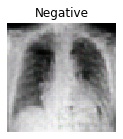

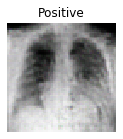

E:35, G Loss:0.04748573899269104, D Loss:1.3185529708862305


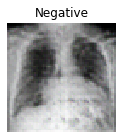

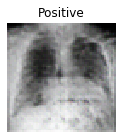

E:36, G Loss:0.013646664097905159, D Loss:1.290292739868164


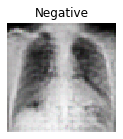

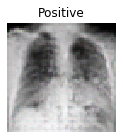

E:37, G Loss:0.058413587510585785, D Loss:1.2605843544006348


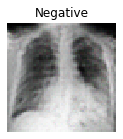

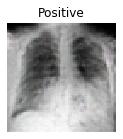

E:38, G Loss:0.028694361448287964, D Loss:1.2611920833587646


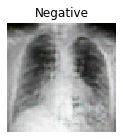

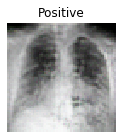

E:39, G Loss:0.035464055836200714, D Loss:1.423914909362793


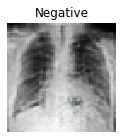

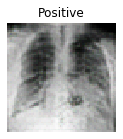

E:40, G Loss:0.046060413122177124, D Loss:1.2401387691497803


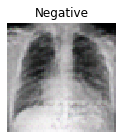

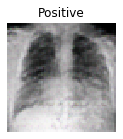

E:41, G Loss:0.034359000623226166, D Loss:1.3284157514572144


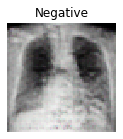

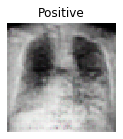

E:42, G Loss:0.037887655198574066, D Loss:1.2668381929397583


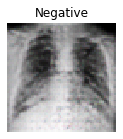

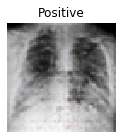

E:43, G Loss:0.05551455169916153, D Loss:1.1745492219924927


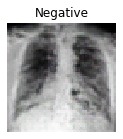

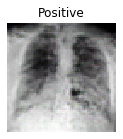

E:44, G Loss:0.04979797080159187, D Loss:1.2387737035751343


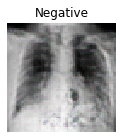

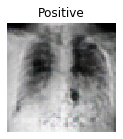

E:45, G Loss:0.023592477664351463, D Loss:1.257967472076416


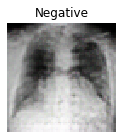

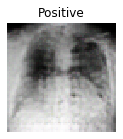

E:46, G Loss:0.032069820910692215, D Loss:1.2339328527450562


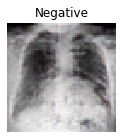

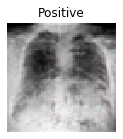

E:47, G Loss:0.04130682721734047, D Loss:1.2105965614318848


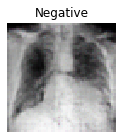

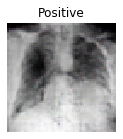

E:48, G Loss:0.03720211610198021, D Loss:1.246065378189087


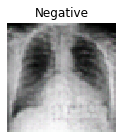

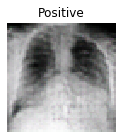

E:49, G Loss:0.04111945256590843, D Loss:1.141362190246582


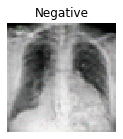

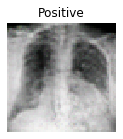

E:50, G Loss:0.05890356004238129, D Loss:1.190845251083374


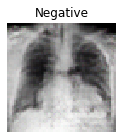

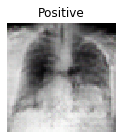

E:51, G Loss:0.036540549248456955, D Loss:1.1749205589294434


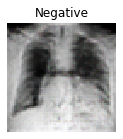

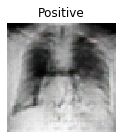

E:52, G Loss:0.06601694971323013, D Loss:1.2012587785720825


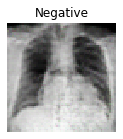

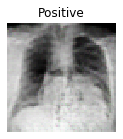

E:53, G Loss:0.04241155460476875, D Loss:1.171560525894165


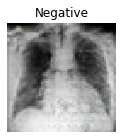

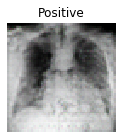

E:54, G Loss:0.07096359133720398, D Loss:1.216173529624939


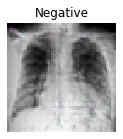

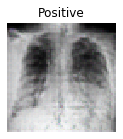

E:55, G Loss:0.0703793466091156, D Loss:1.2155101299285889


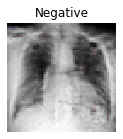

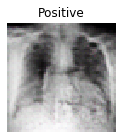

E:56, G Loss:0.053801488131284714, D Loss:1.1914423704147339


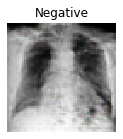

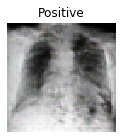

E:57, G Loss:0.036854278296232224, D Loss:1.11744225025177


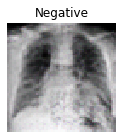

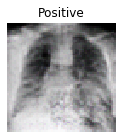

E:58, G Loss:0.06016135588288307, D Loss:1.0650044679641724


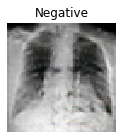

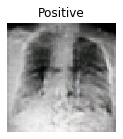

E:59, G Loss:0.057884152978658676, D Loss:1.0794752836227417


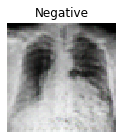

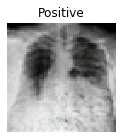

E:60, G Loss:0.06599009037017822, D Loss:1.0989782810211182


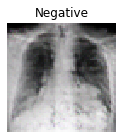

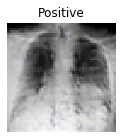

E:61, G Loss:0.05561593547463417, D Loss:1.0837763547897339


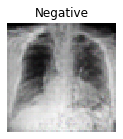

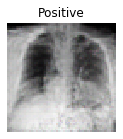

E:62, G Loss:0.04479805752635002, D Loss:1.1188650131225586


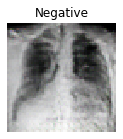

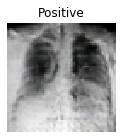

E:63, G Loss:0.03718849644064903, D Loss:1.0948973894119263


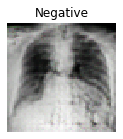

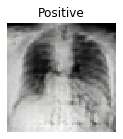

E:64, G Loss:0.05672402307391167, D Loss:1.0516629219055176


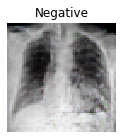

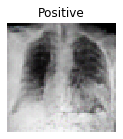

E:65, G Loss:0.06697794049978256, D Loss:1.1156437397003174


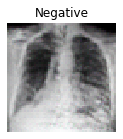

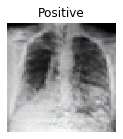

E:66, G Loss:0.04084927961230278, D Loss:1.1313797235488892


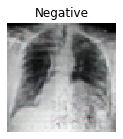

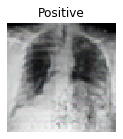

E:67, G Loss:0.03633568808436394, D Loss:0.9861244559288025


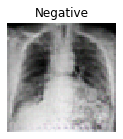

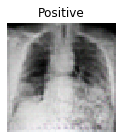

E:68, G Loss:0.05151119828224182, D Loss:1.081101655960083


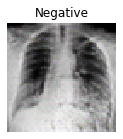

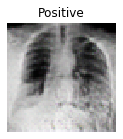

E:69, G Loss:0.04631862789392471, D Loss:1.0254253149032593


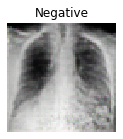

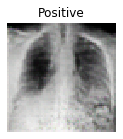

E:70, G Loss:0.03745300695300102, D Loss:1.0435856580734253


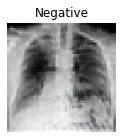

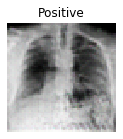

E:71, G Loss:0.058454155921936035, D Loss:1.0093352794647217


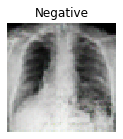

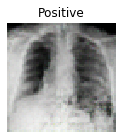

E:72, G Loss:0.039325520396232605, D Loss:1.066563367843628


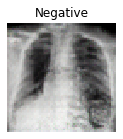

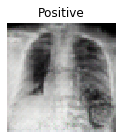

E:73, G Loss:0.06208226829767227, D Loss:1.0681830644607544


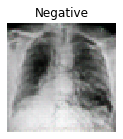

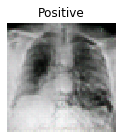

E:74, G Loss:0.07367420941591263, D Loss:1.0123236179351807


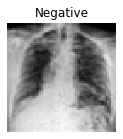

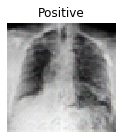

E:75, G Loss:0.0453462079167366, D Loss:1.0608696937561035


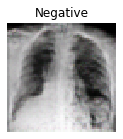

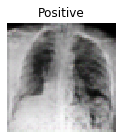

E:76, G Loss:0.058783214539289474, D Loss:1.0044041872024536


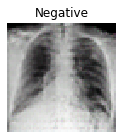

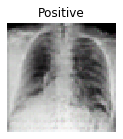

E:77, G Loss:0.04846756160259247, D Loss:1.0206177234649658


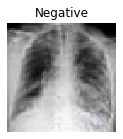

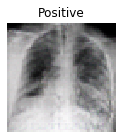

E:78, G Loss:0.06279059499502182, D Loss:0.9819713234901428


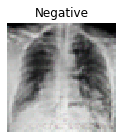

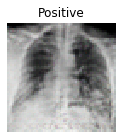

E:79, G Loss:0.09627392888069153, D Loss:0.9626049399375916


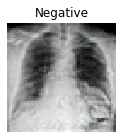

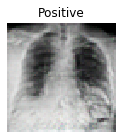

E:80, G Loss:0.0545412041246891, D Loss:0.944347620010376


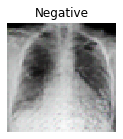

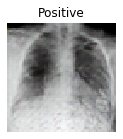

E:81, G Loss:0.06671232730150223, D Loss:1.271935224533081


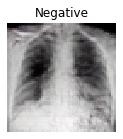

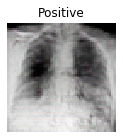

E:82, G Loss:0.019463980570435524, D Loss:0.9623684883117676


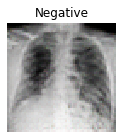

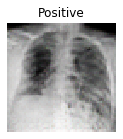

E:83, G Loss:0.04956284165382385, D Loss:0.9340119957923889


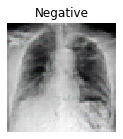

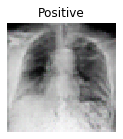

E:84, G Loss:0.04086233675479889, D Loss:0.9390186667442322


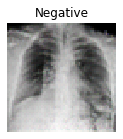

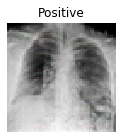

E:85, G Loss:0.06922227889299393, D Loss:0.9077645540237427


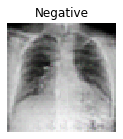

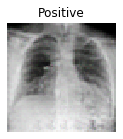

E:86, G Loss:0.08266910165548325, D Loss:0.9052904844284058


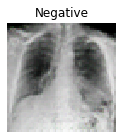

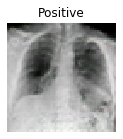

E:87, G Loss:0.04140842333436012, D Loss:0.8887774348258972


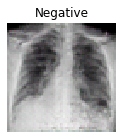

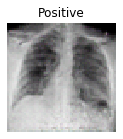

E:88, G Loss:0.07618125528097153, D Loss:0.8754802346229553


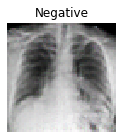

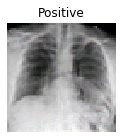

E:89, G Loss:0.05678164213895798, D Loss:0.9014484882354736


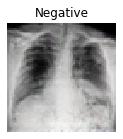

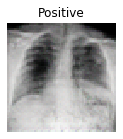

E:90, G Loss:0.0239306278526783, D Loss:1.4384350776672363


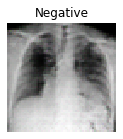

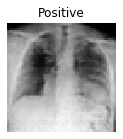

E:91, G Loss:0.05335768312215805, D Loss:1.068376064300537


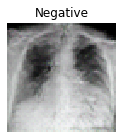

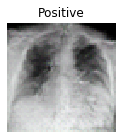

E:92, G Loss:0.07039519399404526, D Loss:0.8923308849334717


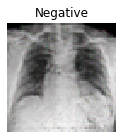

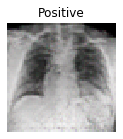

E:93, G Loss:0.061783261597156525, D Loss:0.8823854923248291


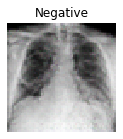

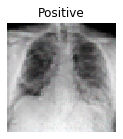

E:94, G Loss:0.04290570318698883, D Loss:0.8338043689727783


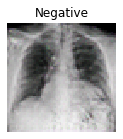

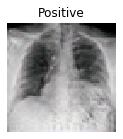

E:95, G Loss:0.057253748178482056, D Loss:0.8499711155891418


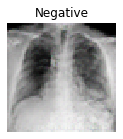

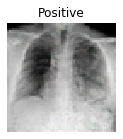

E:96, G Loss:0.051402799785137177, D Loss:0.9502745270729065


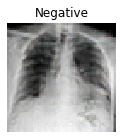

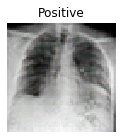

E:97, G Loss:0.05784843862056732, D Loss:0.8660792112350464


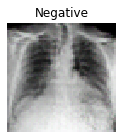

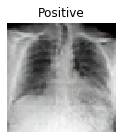

E:98, G Loss:0.0510861910879612, D Loss:0.8583117127418518


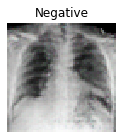

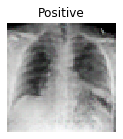

E:99, G Loss:0.05604518577456474, D Loss:0.8679364919662476


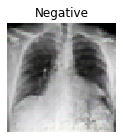

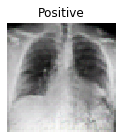

E:100, G Loss:0.052612315863370895, D Loss:0.900484561920166


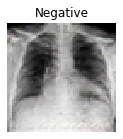

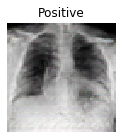

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

import warnings
warnings.filterwarnings("ignore")


for epoch in range(100):

    d_loss = 0
    g_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):

        if i == num_steps:
            break

        for k in range(1):

             d_loss += trainD(images, labels)

        g_loss = trainG(labels)

    
    if epoch % 1 == 0:
        print(
            "E:{}, G Loss:{}, D Loss:{}".format(
                epoch+1,
                g_loss / num_steps,
                d_loss / num_steps / 1
            )
        )

        

        generated_neg = netG(
            fixed_noise_train,
            fixed_conditions_train_neg
        ).detach().cpu().view(
            -1,
            3,
            64,
            64
        )
        
        generated_pos = netG(
            fixed_noise_train,
            fixed_conditions_train_pos
        ).detach().cpu().view(
            -1,
            3,
            64,
            64
        )

        fig=plt.figure(figsize=(2, 2))
        plt.title('Negative')
        plt.axis('off')
        for i in range(1,2):
            minifig= fig.add_subplot(1, 1, i)
            minifig.axis('off')
            #_, label = torch.max(fixed_conditions[i-1], dim = 0)
            #minifig.title.set_text('Label: {}'.format(label))
            image = np.transpose(generated_neg[i-1,:,:,:],(1,2,0))
            image = (image + 1)/2
            plt.imshow(image)
            plt.show()
            
        fig=plt.figure(figsize=(2, 2))
        plt.title('Positive')
        plt.axis('off')
        for i in range(1,2):
            minifig= fig.add_subplot(1, 1, i)
            minifig.axis('off')
            #_, label = torch.max(fixed_conditions[i-1], dim = 0)
            #minifig.title.set_text('Label: {}'.format(label))
            image = np.transpose(generated_pos[i-1,:,:,:],(1,2,0))
            image = (image + 1)/2
            plt.imshow(image)
            plt.show()
        
        
        # Save checkpoint
        torch.save(netG.state_dict(), './Para-GAN_gen.pytorch')
        torch.save(netD.state_dict(), './Para-GAN_disc.pytorch')
        torch.save(optimizerG.state_dict(), './Para-GAN_optGen.pytorch')
        torch.save(optimizerD.state_dict(), './Para-GAN_optDisc.pytorch')

In [78]:
PATH = './lung_generator.pth'
torch.save(netG.state_dict(), PATH)

#### Visualize Result

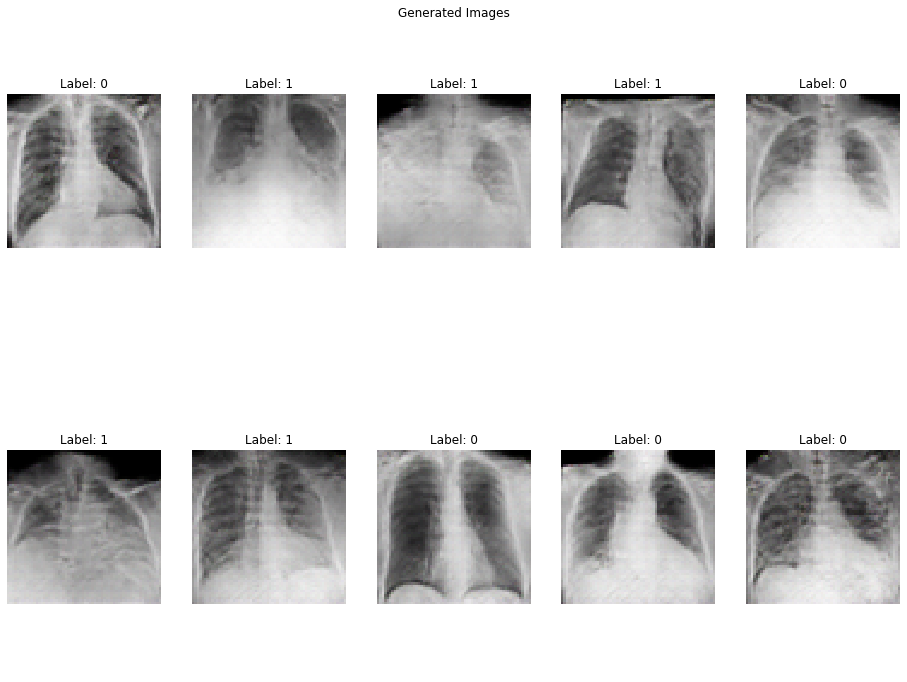

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

fig=plt.figure(figsize=(16, 12))
plt.title('Generated Images')
plt.axis('off')

generated = netG(fixed_noise, fixed_conditions).detach().cpu().view(-1, 3, 64, 64)


for i in range(1,num_examples+1):
    minifig= fig.add_subplot(2, 5, i)
    minifig.axis('off')
    _, label = torch.max(fixed_conditions[i-1], dim = 0)
    minifig.title.set_text('Label: {}'.format(label))
    image = np.transpose(generated[i-1,:,:,:],(1,2,0))
    image = (image + 1)/2
    plt.imshow(image)


plt.show()

#### Latent Space Fixed Noise + Different Label

In [17]:
one_noise = torch.randn(
    1, nz
).to(device)


repeated_noise = one_noise.repeat(nl, 1)

diff_conds = encodeOneHot(
    torch.tensor(
        list(
            range(0, nl)
        )
    )
).to(device)


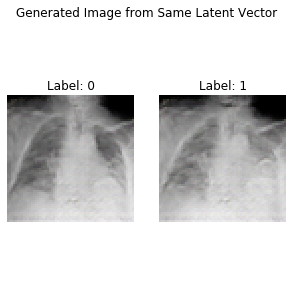

In [18]:
generated = netG(
    repeated_noise,
    diff_conds
).detach().cpu().view(-1, 3, 64, 64)

image_neg = generated[0,:,:,:]
image_pos = generated[1, :, :, :]



fig=plt.figure(figsize=(5, 5))
plt.title('Generated Image from Same Latent Vector')
plt.axis('off')




minifig= fig.add_subplot(1, 2, 1)
minifig.axis('off')
minifig.title.set_text('Label: 0')
image_neg = np.transpose(image_neg,(1,2,0))
image_neg = (image_neg + 1)/2
plt.imshow(image_neg)


minifig= fig.add_subplot(1, 2, 2)
minifig.title.set_text('Label: 1')
minifig.axis('off')
image_pos = np.transpose(image_pos,(1,2,0))
image_pos = (image_pos + 1)/2
plt.imshow(image_pos)


plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


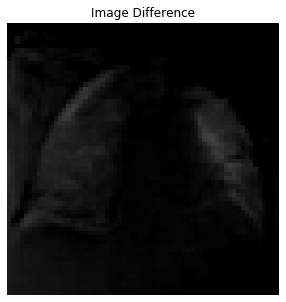

In [19]:



image_difference = image_pos-image_neg

fig=plt.figure(figsize=(5, 5))
plt.title('Image Difference')

plt.axis('off')
plt.imshow(image_difference)














### Latent Space Experimentation


In [60]:
data_test = torchvision.datasets.ImageFolder(
    'C:/Users/avdra/OneDrive/Desktop/GAN-Enabled_Disease_Detection/COVID/one_image_reconstruction_PennApps/',
    transform=torchvision.transforms.Compose([
#         torchvision.transforms.Resize((64, 64)),
        torchvision.transforms.ToTensor(),
        SquashTransform()
    ])
)


test_loader = torch.utils.data.DataLoader(
    data_test,
    batch_size=1,
    shuffle=True,
    num_workers=0, 
    drop_last=True
)

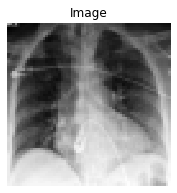

In [61]:
# Plot some images
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt


image = next(iter(test_loader))


plt.figure(figsize=(3, 3))
plt.axis("off")
plt.title("Image")

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            image[0].to(device),
            padding=10,
            normalize=True,
            pad_value=1,
            nrow=int(3 * sqrt(BATCH_SIZE) / 2)
        ).cpu(),
        (1,2,0)
    )
);


In [62]:
import torch
import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss

In [68]:
from torch.autograd import Variable

init_noise = Variable(torch.randn(
    1, nz
).to(device), requires_grad = True)

negative_label = torch.Tensor([[1,0]]).to(device)
positive_label = torch.Tensor([[0,1]]).to(device)

In [69]:
optim = torch.optim.Adam([init_noise], lr=0.1, betas=(0.5, 0.999))  

In [70]:
original_image = image[0].to(device)
mask = torch.ones([1,3,64,64]).to(device)
mask[0,:,4:60,20:60] = 2


E: 1 loss: 7.613761901855469
E: 2 loss: 6.986598968505859
E: 3 loss: 6.659160137176514
E: 4 loss: 6.554637432098389
E: 5 loss: 6.402743816375732
E: 6 loss: 6.321784496307373
E: 7 loss: 6.264106750488281
E: 8 loss: 6.216886043548584
E: 9 loss: 6.17706298828125
E: 10 loss: 6.149415969848633


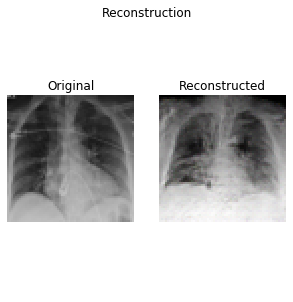

E: 11 loss: 6.126613616943359
E: 12 loss: 6.106724262237549
E: 13 loss: 6.094621658325195
E: 14 loss: 6.0741496086120605
E: 15 loss: 6.066420078277588
E: 16 loss: 6.056746959686279
E: 17 loss: 6.027235507965088
E: 18 loss: 6.014047145843506
E: 19 loss: 5.998150825500488
E: 20 loss: 5.981820583343506


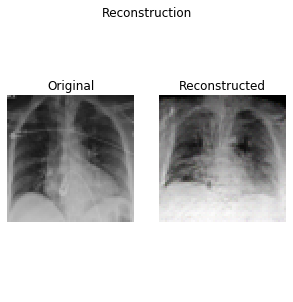

In [71]:
for epoch in range(0,20):
    original_image = image[0].to(device)
    optim.zero_grad()
    sample = netG(init_noise, negative_label ).to(device)
    sample = sample.reshape([1,3,64,64])
    original_image =  original_image.reshape([1,3,64,64])
    loss_func = VGGPerceptualLoss().to(device)
    loss = loss_func(sample, original_image) + 10 * torch.mean(mask*(original_image - sample)**2)
    #loss = 100* torch.mean(mask*(original_image - sample)**2)
    print("E:", epoch+1, "loss:", loss.item())
    loss.backward()
    optim.step()
    
    if (epoch+1) % 10 == 0:
        reconstructed_image = netG(
        init_noise, negative_label
        ).detach().cpu().view(-1, 3, 64, 64)

        reconstructed_image = reconstructed_image[0,]



        fig=plt.figure(figsize=(5, 5))
        plt.title('Reconstruction')
        plt.axis('off')




        minifig= fig.add_subplot(1, 2, 1)
        minifig.axis('off')
        minifig.title.set_text('Original')
        original_image = original_image.cpu().view(3, 64, 64)
        original_image = np.transpose(original_image,(1,2,0))
        original_image = (original_image + 1)/2
        plt.imshow(original_image)


        minifig= fig.add_subplot(1, 2, 2)
        minifig.title.set_text('Reconstructed')
        minifig.axis('off')
        reconstructed_image = np.transpose(reconstructed_image,(1,2,0))
        reconstructed_image = (reconstructed_image + 1)/2
        plt.imshow(reconstructed_image)

        plt.show()

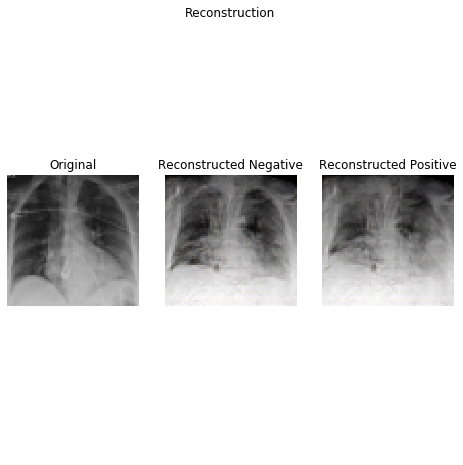

In [72]:
original_image = image[0].to(device)
reconstructed_image_positive = netG(
    init_noise, positive_label
).detach().cpu().view(-1, 3, 64, 64)

reconstructed_image_positive = reconstructed_image_positive[0,]

reconstructed_image_negative = netG(
    init_noise, negative_label
).detach().cpu().view(-1, 3, 64, 64)

reconstructed_image_negative = reconstructed_image_negative[0,]

fig=plt.figure(figsize=(8, 8))
plt.title('Reconstruction')
plt.axis('off')




minifig= fig.add_subplot(1, 3, 1)
minifig.axis('off')
minifig.title.set_text('Original')
original_image = original_image.cpu().view(3, 64, 64)
original_image = np.transpose(original_image,(1,2,0))
original_image = (original_image + 1)/2
plt.imshow(original_image)

minifig= fig.add_subplot(1, 3, 2)
minifig.axis('off')
minifig.title.set_text('Reconstructed Negative')
reconstructed_image_negative = np.transpose(reconstructed_image_negative,(1,2,0))
reconstructed_image_negative = (reconstructed_image_negative + 1)/2
plt.imshow(reconstructed_image_negative)




minifig= fig.add_subplot(1, 3, 3)
minifig.title.set_text('Reconstructed Positive')
minifig.axis('off')
reconstructed_image_positive = np.transpose(reconstructed_image_positive,(1,2,0))
reconstructed_image_positive = (reconstructed_image_positive + 1)/2
plt.imshow(reconstructed_image_positive)


plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


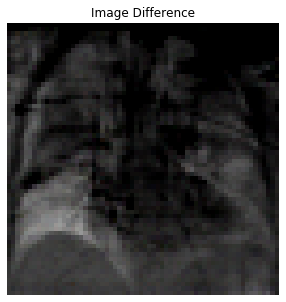

In [76]:
image_difference = reconstructed_image_positive-original_image

fig=plt.figure(figsize=(5, 5))
plt.title('Image Difference')

plt.axis('off')
plt.imshow(image_difference)












